# Graph Structure
The coupling $J_{i,j}(\sigma_i,\sigma_j)$ will be take into account only if an edge exist between site i and j

The cython extension is already loaded. To reload it, use:
  %reload_ext cython


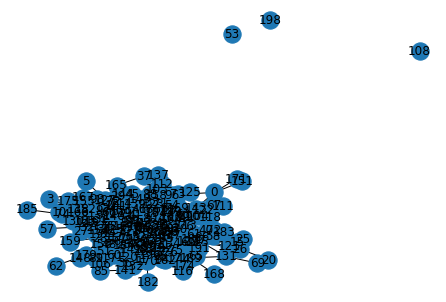

In [46]:
%load_ext cython
%config IPCompleter.greedy=True 
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

N = 200 #Number of node in the graph 200 Nicola
p = 0.02 ##proba two nodes connected 
Graph =nx.erdos_renyi_graph(N,p)
Layout = nx.drawing.layout.fruchterman_reingold_layout(Graph) ##For having the same layout at each drawing
nx.draw(Graph,with_labels=True,pos=Layout)

# Generation of Data for spin with more than two states
In the case of the Potts model :
$$
P(\sigma_1,.,\sigma_N) = \frac{\exp\left[\frac{1}{T}\left({\sum_{i=1}^N  h_i(\sigma_i) + \sum_{i,j} J_{i,j}(\sigma_i,\sigma_j)}\right) \right]}{ Z}
$$
What I need to generate data is :
$$
J_{i,j}(\sigma_i,\sigma_j)  \text{ and } h_i(\sigma_i) 
$$
The metropolis algo implies :
$$: 
P_{a\rightarrow b} = min[1,\frac{\pi(b)}{\pi(a)}] = min\left[1,\exp \left( \frac{1}{T} \left({{\sum_{i=1}^N  h_i(\sigma_i^b)- h_i(\sigma_i^a) + \sum_{i,j} J_{i,j}(\sigma_i^b,\sigma_j^b) - J_{i,j}^a(\sigma_i^a,\sigma_j^a)}}\right)\right) \right]
$$
where $P_{a\leftarrow b}$ is the transition probability in the MCMC algo and $\pi(a)$ the stationnary probability of being in the state b, i.e $P(\sigma_1,.,\sigma_N)$.

IMPORTANT :
Choice of Ising Gauge : 
$$
\sum_{\sigma_i} J_{i,j}(\sigma_i,\sigma_j) = \sum_{\sigma_j} J_{i,j}(\sigma_i,\sigma_j) = 0
$$
To go in this Gauge, we infer $J_ij$ with $J_{i,j} = C^{-1}_{i,j}$ and after we apply :
$$
J^{Ising}_{i,j}(\sigma_i,\sigma_j) = J_{i,j}(\sigma_i,\sigma_j) - \frac{1}{q}\sum_{\sigma_i} J_{i,j}(\sigma_i,\sigma_j)  - \frac{1}{q} \sum_{\sigma_j} J_{i,j}(\sigma_i,\sigma_j) + \frac{1}{q^2} \sum_{\sigma_i,\sigma_j} J_{i,j}(\sigma_i,\sigma_j) 
$$
where q is the number of state for $\sigma$

In [47]:
%%cython --f
import numpy as np
cimport cython
from libc.stdlib cimport RAND_MAX
from posix.stdlib cimport random, srandom
from libc.math cimport exp
from libc.time cimport time


cdef class Creation_MSA:
    """
    Spin = index of the possible state (i.e classic spin +-1 --> 0 or 1)
    """
    cdef double[:,::1] Field
    cdef double[:,:,:,::1] Coupling
    cdef int Number_state_spin
    cdef int[:,:] M_neighboors
    cdef int Number_of_Node
    cdef public int Flip_equilibrium_standard_algo
    cdef public float Temperature
    cdef float Number_of_node_divided_RANDMAX
    
    def __init__(self, Graph, double[:,::1] Field_h, double[:,:,:,::1] Coupling_J,float Temperature, int Flip_equilibrium_standard_algo ):
        """
        Input:
        Graph : networkx graph
        double[:,::1] Field_h : h_i(\sigma_i)
        double[:,:,:,::1] Coupling_J : J_{i,j}(\sigma_i,\sigma_j)
        float Temperature 
        int Flip_equilibrium_standard_algo : Number of flip to do 
        """
        self.Number_state_spin = np.intc(Field_h.shape[1])
        self.Temperature = Temperature
        self.Field = Field_h
        self.Coupling = Coupling_J
        self.Number_of_Node = np.intc(Graph.number_of_nodes())
        self.Flip_equilibrium_standard_algo = Flip_equilibrium_standard_algo
        M_neighboors = -1*np.ones((Graph.number_of_nodes(),Graph.number_of_nodes()),dtype=np.intc)
        M_neighboors = np.array(M_neighboors,dtype=np.intc)
        for node in range(Graph.number_of_nodes()):
            L_neigh = [n for n in Graph.neighbors(node)]
            if len(L_neigh)>0:
                M_neighboors[node,:len(L_neigh)] = np.array(L_neigh,dtype=np.intc)
        self.M_neighboors = M_neighboors
        self.Number_of_node_divided_RANDMAX = float(self.Number_of_Node) / float(RAND_MAX)
        srandom(<unsigned int>time(NULL))
      
    @cython.boundscheck(False)
    @cython.wraparound(False)
    @cython.initializedcheck(False)
    def MSA_Equilibrium(self, int Number_Sequence_in_MSA, MSA = None ):
        if np.sum(MSA) == None:
            MSA = np.random.randint(self.Number_state_spin , size = (Number_Sequence_in_MSA,self.Number_of_Node),dtype = np.int8)
        cdef:
            int index_MSA
            char[:,::1] MSA_view = MSA
        for index_MSA in range(MSA_view.shape[0]):
            self.MCMC_adjency_cython_2(self.Flip_equilibrium_standard_algo, MSA_view[index_MSA])
        return MSA
                          
    @cython.boundscheck(False)
    @cython.wraparound(False)
    @cython.initializedcheck(False)
    def Hamiltonian(self,char[::1] L_Spin):
        cdef:
            int node_i,index_neighboor
            double hamiltonian = 0
        for node_i in range(self.M_neighboors.shape[0]):
            hamiltonian -= self.Field[node_i,L_Spin[node_i]]
            for index_neighboor in range(self.M_neighboors.shape[1]):
                if self.M_neighboors[node_i,index_neighboor] == -1:
                    break
                elif self.M_neighboors[node_i,index_neighboor]>node_i: ## Edge already include in hamiltonian ? 
                        hamiltonian -= self.Coupling[node_i,self.M_neighboors[node_i,index_neighboor],L_Spin[node_i],L_Spin[self.M_neighboors[node_i,index_neighboor]]]
        return hamiltonian 
    
    @cython.boundscheck(False)
    @cython.wraparound(False)
    @cython.initializedcheck(False)
    cpdef void MCMC_adjency_cython_2(self, int Number_of_Mutation, char[::1] L_Spin):  
        cdef:
            int selected_node, new_state, c_mutation = 0
            double Prob 
        while c_mutation<Number_of_Mutation:   
            selected_node = int(self.Number_of_node_divided_RANDMAX* float(random()))
            new_state = int((self.Number_state_spin-1)*float(random())/float(RAND_MAX))
            if new_state >= L_Spin[selected_node]:
                new_state += 1 
            Prob = exp(1/(self.Temperature)*(self.Pseudo_Hamiltonian(selected_node, new_state, L_Spin) -
                                              self.Pseudo_Hamiltonian(selected_node, L_Spin[selected_node], L_Spin)))
            if float(random())/float(RAND_MAX)<Prob:
                L_Spin[selected_node]= new_state
                c_mutation += 1


    @cython.boundscheck(False)
    @cython.wraparound(False)
    @cython.initializedcheck(False)
    cdef double Pseudo_Hamiltonian(self, int node, int state_node, char[::1] L_Spin):
        cdef:
            int i
            double hamiltonian = 0
        hamiltonian = self.Field[node,state_node]
        for i in range(self.M_neighboors.shape[1]):
                if self.M_neighboors[node,i] == -1:
                    break
                else:
                    hamiltonian += self.Coupling[node,self.M_neighboors[node,i],state_node,L_Spin[self.M_neighboors[node,i]]]
        return hamiltonian 
    
    
    @cython.boundscheck(False)
    @cython.wraparound(False)
    @cython.initializedcheck(False)
    cdef int item_in_liste(self, int[::1] List, int item):
        cdef int item_liste, index_item_liste
        for index_item_liste in range(len(List)):
            item_liste = List[index_item_liste]
            if item_liste == item:
                return 1
            if item_liste == -1:
                break
        return 0

## Generation of your MSA

In [48]:
Number_of_sequence_in_MSA = 100
#Set field, coupling, and Temperature
J = np.diagflat([2]*20) - 1
Number_of_state = J.shape[0]

Coupling_J = np.array(np.broadcast_to(J,(Graph.number_of_nodes(),Graph.number_of_nodes(),Number_of_state,Number_of_state)),order = 'C',dtype=float) 
Field_h = np.zeros((Graph.number_of_nodes(),Number_of_state),dtype = float)

Temperature = 2

#Number of Flip accepted to do:
Flip_equi = 4000 #You need to choose the good number of flip (You could look at the hamiltonian to choose)

#Creation of the Class:
Class_MSA_Generation = Creation_MSA(Graph, Field_h, Coupling_J, Temperature, Flip_equi)

MSA = Class_MSA_Generation.MSA_Equilibrium(Number_of_sequence_in_MSA)

In [49]:
print(MSA)

[[ 5  3  6 ...  3 18  6]
 [ 0 19 13 ...  7  2  0]
 [ 3 13 11 ... 14 12  1]
 ...
 [ 6  3  6 ... 10 16  6]
 [16 19  8 ... 18  1 18]
 [17  7 10 ... 11  9  5]]


### Bonus plot the hamiltonian to see when equilibrium is reached

In [50]:
import numpy as np 

Number_average = 1
Delta_Flip = 100
Max_Flip = 10**5
LT = [0.5,1,2,3,4,5]

Class_MSA_Generation = Creation_MSA(Graph, Field_h, Coupling_J, Temperature, Delta_Flip)

L_energy = np.zeros((len(LT),Max_Flip//Delta_Flip))
L_energy_var = np.zeros((len(LT),Max_Flip//Delta_Flip))

for index_T,Temperature in enumerate(LT):
    MSA = np.random.randint(Number_of_state , size = (Number_of_sequence_in_MSA ,Graph.number_of_nodes()),dtype = np.int8)
    print("T = " + str(Temperature))
    Class_MSA_Generation.Temperature = Temperature
    for index_flip in range(Max_Flip//Delta_Flip):
        Halmitonian = [ Class_MSA_Generation.Hamiltonian(MSA[index_msa]) for index_msa in range(Number_of_sequence_in_MSA)]
        L_energy[index_T,index_flip] = np.mean(Halmitonian)
        Class_MSA_Generation.MSA_Equilibrium(1,MSA)



T = 0.5
T = 1
T = 2
T = 3
T = 4
T = 5


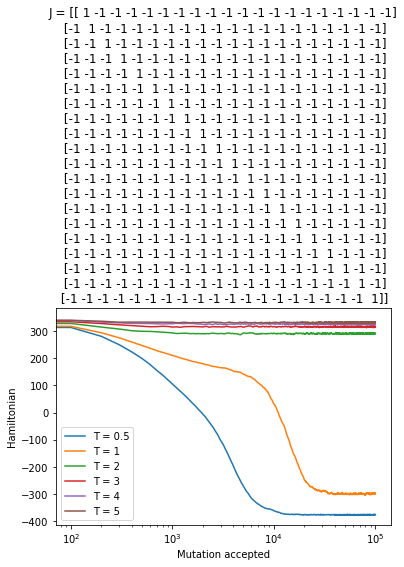

In [51]:
L_flip = np.arange(Max_Flip//Delta_Flip)*Delta_Flip
for index_T,Temperature in enumerate(LT):
    plt.plot(L_flip,L_energy[index_T],label = "T = %s"%Temperature)
plt.xlabel("Mutation accepted")
plt.ylabel("Hamiltonian")
plt.title("J = %s" %J)
plt.semilogx()
plt.legend()
plt.show()